In [1]:
import pandas as pd
import yfinance as yf
import bt
from btpp.strategy import dual_momentum_strategy, saa_weight_strategy
from btpp.helper import get_start_date_off, get_real_start_trading_date
%matplotlib inline

#########################################
# Code For Dual Momentum Strategy(DM)
#########################################

In [2]:
#########################################

portfolios = [
    {
        "name": "SPY/TLT",
        "in_market": ["SPY"],
        "out_market": ["TLT"]
    },
    {
        "name": "QQQ/TLT",
        "in_market": ["QQQ"],
        "out_market": ["TLT"]
    },
    {
        "name": "S;V/TLT",
        "in_market": ["SPY", "VWO"],
        "out_market": ["TLT"]
    },
    {
        "name": "S;Q/TLT",
        "in_market": ["SPY", "QQQ"],
        "out_market": ["TLT"]
    },
    {
        "name": "S;I/TLT",
        "in_market": ["SPY", "IWS"],
        "out_market": ["TLT"]
    },
    {
        "name": "S;V;Q/TLT",
        "in_market": ["SPY", "VWO", "QQQ"],
        "out_market": ["TLT"]
    },
    {
        "name": "S;V;I/TLT",
        "in_market": ["SPY", "VWO", "IWS"],
        "out_market": ["TLT"]
    },
    {
        "name": "S;Q;V;I/TLT",
        "in_market": ["SPY", "QQQ", "VWO", "IWS"],
        "out_market": ["TLT"]
    },
    {
        "name": "S;Q;V;TIP/TLT",
        "in_market": ["SPY", "QQQ", "VWO", "TIP"],
        "out_market": ["TLT"]
    },
    {
        "name": "S;Q;V;I;I/TLT",
        "in_market": ["SPY", "QQQ", "VWO", "IWS", "IJH"],
        "out_market": ["TLT"]
    }
]

benchmarks = [
    {
        "name": "SPY+QQQ+VWO",
        "weight": {"SPY": 0.34, "QQQ": 0.33, "VWO": 0.33}
    }
]

lookbacks = [1, 3, 6]  # Month
lookback_weights = [1, 1, 1]  # Ratio

start_trading_date = "2000-01-01"
end_trading_date = "2021-12-12"
#########################################

In [3]:
tickers_in_market = sum([p["in_market"] for p in portfolios], [])
tickers_out_market = sum([p["out_market"] for p in portfolios], [])
tickers_benchmark = sum([list(it["weight"].keys()) for it in benchmarks], [])

tickers_all = list(
    set(tickers_in_market + tickers_out_market + tickers_benchmark))
print("# All Tickers:")
print(tickers_all)

# All Tickers:
['IWS', 'SPY', 'TLT', 'QQQ', 'TIP', 'IJH', 'VWO']


In [4]:
# Momentum 계산을 위해 6개월 전 데이터부터 가져옴
month_offset = max(lookbacks)
start_date_off = get_start_date_off(
    start_trading_date, month_offset=month_offset)
print(start_date_off)

1999-06-29


In [5]:
# d = bt.get(["spy", "agg"], start="2010-01-01")
# 'Adj Close'를 이용하여 가격 조정
_d = yf.download(tickers_all, start=start_date_off, end=end_trading_date)
d = _d['Adj Close'].dropna()
print(d.head())

[*********************100%***********************]  7 of 7 completed
                  IJH        IWS        QQQ        SPY        TIP        TLT  \
Date                                                                           
2005-03-10  52.474094  26.624893  32.720104  86.303619  61.797855  52.049671   
2005-03-11  52.474094  26.601767  32.414894  85.698593  61.532894  51.669880   
2005-03-14  52.861473  26.786829  32.563145  86.232475  61.650700  51.979549   
2005-03-15  52.564079  26.661905  32.301540  85.520584  61.568253  51.652309   
2005-03-16  52.196262  26.395893  31.935246  84.794540  61.797855  51.967861   

                  VWO  
Date                   
2005-03-10  16.242001  
2005-03-11  16.222567  
2005-03-14  16.125425  
2005-03-15  15.775722  
2005-03-16  15.639716  


In [6]:
# 데이터는 모멘텀 계산을 위해 6개월 이전부터 가져왔지만, 백테스트는 지정한 일자부터 시작함
first_date_of_data = d.index[0].date().isoformat()
real_start_trading_date = get_real_start_trading_date(
    first_date_of_data, month_offset=month_offset)
print("# Firtst Date of Data: ", end="")
print(first_date_of_data)
print("# Real Start Trading Date: ", end="")
print(real_start_trading_date)

# Firtst Date of Data: 2005-03-10
# Real Start Trading Date: 2005-09-12


In [7]:
# Benchmark
benchmark_strategys = [saa_weight_strategy(pf["name"], assets_with_weight=pf["weight"],
                                           run_term="monthly", start_trading_date=real_start_trading_date) for pf in benchmarks]
benchmark_tests = [bt.Backtest(s, d) for s in benchmark_strategys]

In [8]:
# 종목을 바꾸어가며 듀얼 모멘텀 테스트
strategys = [
    dual_momentum_strategy(
        pf["name"],
        n=1,
        alternative_n=1,
        lookbacks=lookbacks,
        lookback_weights=lookback_weights,
        assets=pf["in_market"],
        alternative_assets=pf["out_market"],
        all_or_none=False,
        start_trading_date=real_start_trading_date
    ) for pf in portfolios
]

tests = [bt.Backtest(s, d) for s in strategys]

In [9]:
res = bt.run(*benchmark_tests, *tests)
# res = bt.run(*tests)

SPY+QQQ+VWO:2005-10-03 00:00:00. Value:1000000, Price:100.0000
{'selected': ['IJH', 'IWS', 'QQQ', 'SPY', 'TIP', 'TLT', 'VWO'], 'weights': {'SPY': 0.34, 'QQQ': 0.33, 'VWO': 0.33}}
SPY+QQQ+VWO:2005-11-01 00:00:00. Value:973183, Price:97.3183
{'selected': ['IJH', 'IWS', 'QQQ', 'SPY', 'TIP', 'TLT', 'VWO'], 'weights': {'SPY': 0.34, 'QQQ': 0.33, 'VWO': 0.33}}
SPY+QQQ+VWO:2005-12-01 00:00:00. Value:1043870, Price:104.3870
{'selected': ['IJH', 'IWS', 'QQQ', 'SPY', 'TIP', 'TLT', 'VWO'], 'weights': {'SPY': 0.34, 'QQQ': 0.33, 'VWO': 0.33}}
SPY+QQQ+VWO:2006-01-03 00:00:00. Value:1067421, Price:106.7421
{'selected': ['IJH', 'IWS', 'QQQ', 'SPY', 'TIP', 'TLT', 'VWO'], 'weights': {'SPY': 0.34, 'QQQ': 0.33, 'VWO': 0.33}}
SPY+QQQ+VWO:2006-02-01 00:00:00. Value:1108993, Price:110.8993
{'selected': ['IJH', 'IWS', 'QQQ', 'SPY', 'TIP', 'TLT', 'VWO'], 'weights': {'SPY': 0.34, 'QQQ': 0.33, 'VWO': 0.33}}
SPY+QQQ+VWO:2006-03-01 00:00:00. Value:1106006, Price:110.6006
{'selected': ['IJH', 'IWS', 'QQQ', 'SPY', 'T

In [10]:
res.display()

Stat                 SPY+QQQ+VWO    SPY/TLT     QQQ/TLT     S;V/TLT     S;Q/TLT     S;I/TLT     S;V;Q/TLT    S;V;I/TLT    S;Q;V;I/TLT    S;Q;V;TIP/TLT    S;Q;V;I;I/TLT
-------------------  -------------  ----------  ----------  ----------  ----------  ----------  -----------  -----------  -------------  ---------------  ---------------
Start                2005-03-09     2005-03-09  2005-03-09  2005-03-09  2005-03-09  2005-03-09  2005-03-09   2005-03-09   2005-03-09     2005-03-09       2005-03-09
End                  2021-12-10     2021-12-10  2021-12-10  2021-12-10  2021-12-10  2021-12-10  2021-12-10   2021-12-10   2021-12-10     2021-12-10       2021-12-10
Risk-free rate       0.00%          0.00%       0.00%       0.00%       0.00%       0.00%       0.00%        0.00%        0.00%          0.00%            0.00%

Total Return         468.28%        378.99%     793.71%     500.05%     592.08%     412.78%     783.22%      493.79%      684.56%        760.97%          750.17%
Daily Sha

<AxesSubplot:title={'center':'Equity Progression'}>

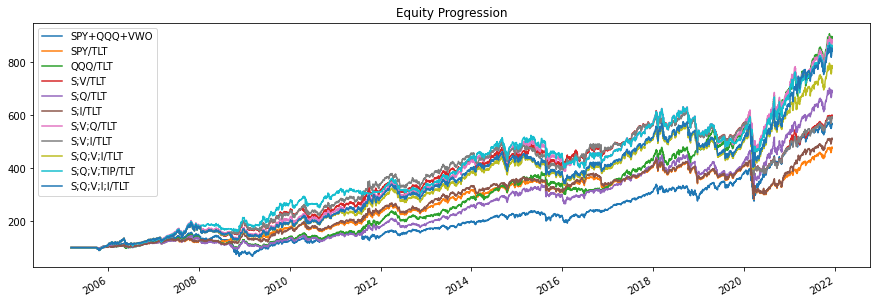

In [11]:
res.plot()

In [12]:
# res.prices

In [13]:
# res.stats